# Pytorch Workflow
We will explore an end-to-end pytorch workflow
Resources:
* Notebook: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version: https://www.learnpytorch.io/01_pytorch_workflow/

In [ ]:
# importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn # nn 'neural network' contains all the building blocks for
# neural networks in Pytorch

## 1. Data (preparing and loading)
Data can be literally anything in machine learning
- Excel Spreadsheets
- Images
- Videos
- Audio
- DNA
- Text   

Machine learning is a game of two parts:
1. Turn data into numbers
2. Build a model, train it and make predictions

In [ ]:
import torch
# we will build some known data using a linear regression
# params
weight = 0.9
bias = 0.3
# data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

### Splitting data into training and test sets
* training set -> Course materials, used to learn patterns
* validation set -> Practicals, used to tune the model patterns, not always required
* test set -> Exams, to see whether the model is ready for production or no

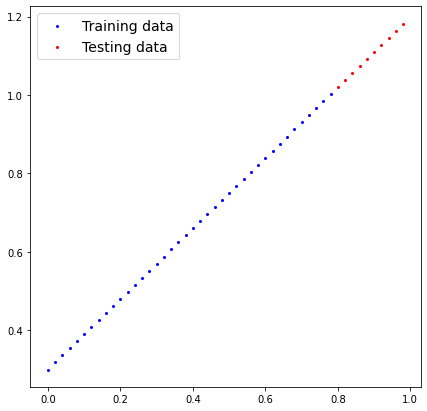

In [ ]:
import matplotlib.pyplot as plt

# create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
 # building a function to visualize our data
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  plt.figure(figsize=(7, 7))
  plt.scatter(train_data, train_labels, c='b', s=4, label = "Training data")
  plt.scatter(test_data, test_labels, c='r', s=4, label = 'Testing data')
  if predictions is not None:
    plt.scatter(test_data, predictions, c='g', s=4, label='Predictions')
  plt.legend(prop={"size":14})
  plt.show()
plot_predictions()


## 2. Building Model
Deep Learning models in Pytorch are classes that inherits from the `nn.Module`, as explained earlier there are two main steps:
1. Start with random variables
2. Compute, tune, redo    
 
Tuning our parameters is done thanks to two algorithms: [3Blue1Brown]
1. Gradient Descent
2. Backpropagation


In [ ]:
import torch
from torch import nn
# Create a linear regression model
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # we will start with random parameters, do computations then adjust them
    # requires_grad is by default True for parameters
    self.weight = nn.Parameter(torch.randn(1,
                                           requires_grad=True,
                                           dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  # we create a forward function to do the computations
  # any subclass of the nn.Module should override the forward function
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weight * x + self.bias


### PyTorch model building essentials
* torch.nn - contains all of the building blocks for neural networks "computational graphs"
* torch.nn.Parameter - what parameters should our model try and learn, often a Pytorch layer
* torch.nn.Module - base class for all neural networks modules, if we subclass it we shoudl override the forward function
* torch.optim - this where we find the optimizers used to tune the parameters 
* def forward() - all nn.Module subclasses require you to oerwrite it

In [ ]:
# setting a random seed 
torch.manual_seed(42) 
model = LinearRegressionModel()
model.weight, model.bias

(Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True))

In [ ]:
# getting all parameters
list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# we aslo can state the params with their name
model.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using  `torch.inference_mode()`
We will predict the value of `y_test` based on `X_test`

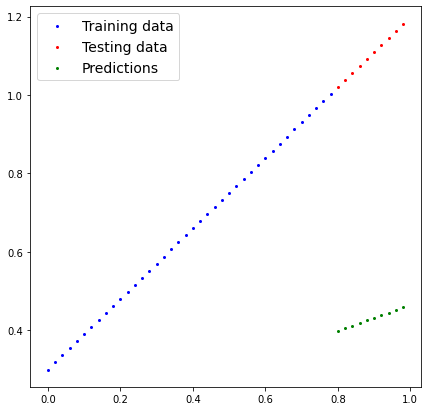

In [ ]:
# Make predictions
# we use a context manager in order to turn off the gardients tracking
# befor, we used to use no_grad(), but it's deprecated
with torch.inference_mode():
  y_pred = model(X_test)
plot_predictions(predictions=y_pred)

## 3. Train model
That means tuning the parameters to move from a poor representations of the data to
a better representation

* First  of all we should measure how poor our model is by using a **loss function** also called a **cost function** or **criterion**, then use it to tune the parameters thanks to the **optimizer**. 

- **Loss function:** Function to measure how wrong your model's predictions are to the ideal outputs
- **Optimizer:** Takes into accounts the loss then adjust the parameters, you always have to set the parameters you want to adjust and the learning rate you're going to use

In [ ]:
# there is two ways to compute the mean absolute error
# mae = torch.mean(torch.abs(y_pred - y_test))
# mae = torch.nn.l1loss(y_pred, y_test)

# setup a loss function
loss_fn = nn.L1Loss()
# setup an optimizer "Stochastic Gradient Descent"
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01) #lr = learning rate (hyperparameter, a param we set ourself)

### Building a training loop (and a testing one) in Pytorch
We will need a couple of things for a training loop:
1. Loop through the Data
2. Forward Pass [Data moving through our model forward], also called "forward propagation"
3. Calculate the loss 
4. Optimizer zero grad
5. Loss backward to compute the gradients of the params with respect to the loss (**backpropagation**)
6. Optimizer step (**gradient descent**)

**Remark:** In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero before starting to do backpropragation (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes. 

In [ ]:
# an epoch is one loop through the data
epochs = 450 #hyperparameter
# tracking values
epoch_count = []
loss_values = []
test_loss_values = []

### training
eps = [i for i in range(epochs)]
# 0. loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model.train() # sets requires_grad() to True for all parameters that require it
  # 1. Forward pass
  y_preds = model(X_train)

  # 2. Loss
  loss = loss_fn(y_preds, y_train)
  # 3. Optimizer zero_grad
  optimizer.zero_grad() # so that the optim

  # 4. Back Prop
  loss.backward()
  
  # 5. Gradient Descent
  optimizer.step()

  ### Testing 
  model.eval() # turns off gradients tracking and settings not needed for evaluation
  # for instance it turns off the dropout layer if used
  with torch.inference_mode():
    y_pred_test = model(X_test)
    loss_test = loss_fn(y_pred_test, y_test)
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss.item())
    test_loss_values.append(loss_test.item())
    print(f"Epoch : {epoch} | Train : {loss} | Test : {loss_test}")

Epoch : 0 | Train : 0.39088135957717896 | Test : 0.6590651273727417
Epoch : 10 | Train : 0.2756713330745697 | Test : 0.5243551731109619
Epoch : 20 | Train : 0.16460572183132172 | Test : 0.3926808834075928
Epoch : 30 | Train : 0.10852336883544922 | Test : 0.2989806532859802
Epoch : 40 | Train : 0.08743593096733093 | Test : 0.24060264229774475
Epoch : 50 | Train : 0.07890807092189789 | Test : 0.20496833324432373
Epoch : 60 | Train : 0.07424996793270111 | Test : 0.18382300436496735
Epoch : 70 | Train : 0.07052046060562134 | Test : 0.17009106278419495
Epoch : 80 | Train : 0.06703047454357147 | Test : 0.15907101333141327
Epoch : 90 | Train : 0.06354047358036041 | Test : 0.1480509340763092
Epoch : 100 | Train : 0.06010167673230171 | Test : 0.13977840542793274
Epoch : 110 | Train : 0.05666285753250122 | Test : 0.1315058469772339
Epoch : 120 | Train : 0.053229380398988724 | Test : 0.12392017990350723
Epoch : 130 | Train : 0.049798037856817245 | Test : 0.11564763635396957
Epoch : 140 | Train : 

In [ ]:
model.state_dict()

OrderedDict([('weight', tensor([0.8940])), ('bias', tensor([0.2968]))])

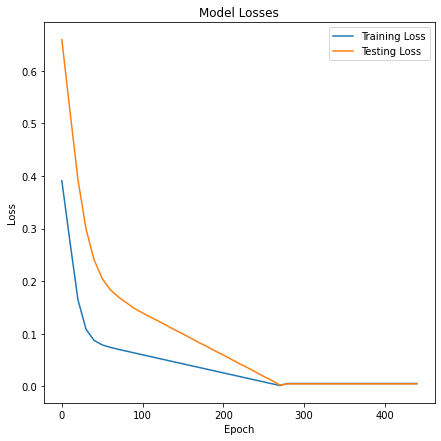

In [ ]:
# plotting loss 
def plot_loss(epoch_count=epoch_count, loss_values=loss_values, test_loss_values=test_loss_values):
  plt.figure(figsize=(7, 7))
  plt.plot(epoch_count, loss_values, label="Training Loss")
  plt.plot(epoch_count, test_loss_values, label="Testing Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Model Losses")
  plt.legend(loc='best')
  plt.show()
plot_loss()

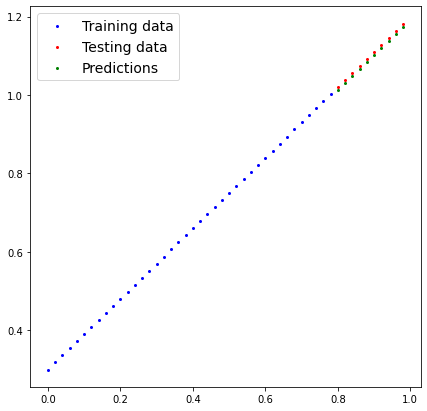

In [ ]:
with torch.inference_mode():
  y_pred = model(X_test)
plot_predictions(predictions=y_pred)

## Saving and loading the model
   There are three main methods you should know about saving and loading models in PyTorch:
1. `torch.save` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to save a PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary
**Remarks:**   

- It is recommanded to save the state dictionnary of the model instead of saving the whole model because it contains all the necessary information.
- https://pytorch.org/tutorials/beginner/saving_loading_models.html
- As a convention, we save PyTorch related objects with the extension .pt or .pth
- Notice that the load_state_dict() function takes a dictionary object, NOT a path to a saved object.
- The disadvantage of this approach is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved. The reason for this is because pickle does not save the model class itself. Rather, it saves a path to the file containing the class, which is used during load time. Because of this, your code can break in various ways when used in other projects or after refactors.
- You can also save several models in one file using a dictionary.



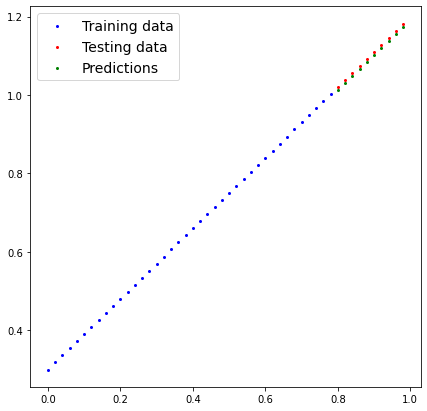

In [ ]:
# saving the model state dict
from pathlib import Path # python's module to deal with paths

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "our_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Saving the state_dict

torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
# loading the model
# we should create a new instance of our LinearRegression model class 
model2 = LinearRegressionModel()
model2.load_state_dict(torch.load(MODEL_SAVE_PATH))
# Make some predictions
model2.eval()
with torch.inference_mode():
  y_predss = model2(X_test)
plot_predictions(predictions=y_predss)


## Putting everything altogether

In [ ]:
import torch
from torch import nn


# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class LinearRegressionModelAdjusted(nn.Module):
  def __init__(self, device):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1,
                              requires_grad=True,
                              dtype=torch.float,
                              device=device))
    self.bias = nn.Parameter(torch.randn(1,
                            requires_grad=True,
                            dtype=torch.float,
                            device=device))
    
  def forward(self, x: torch.tensor) -> torch.tensor:
      return self.weight * x + self.bias

  def train_loop(self, df_train, df_test, epochs = 400, verbose = True):
      X_train, y_train = df_train
      X_test, y_test = df_test
      epoch_count = []
      train_loss = []
      test_losses = []
      loss_fn = nn.L1Loss()
      optimizer = torch.optim.SGD(params=self.parameters(), lr=0.01)
      for epoch in range(epochs):
        self.train()
        y_pred = self.forward(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        self.eval()
        with torch.inference_mode():
          y_test_pred = self.forward(X_test)
          test_loss = loss_fn(y_test_pred, y_test)

        if epoch%10 == 0:
          epoch_count.append(epoch)
          train_loss.append(loss.item())
          test_losses.append(test_loss.item())
          if verbose:
            print(f"Epoch : {epoch} | Train Loss : {loss} | Test Loss : {test_loss}")
      return epoch_count, train_loss, test_loss
          


        

    

In [ ]:
torch.manual_seed(42)
model_test = LinearRegressionModelAdjusted(device)

In [ ]:
train_d = X_train, y_train
test_d = X_test, y_test
model_test.train_loop(train_d, test_d)

Epoch : 0 | Train Loss : 0.39088135957717896 | Test Loss : 0.6590651273727417
Epoch : 10 | Train Loss : 0.2756713330745697 | Test Loss : 0.5243551731109619
Epoch : 20 | Train Loss : 0.16460572183132172 | Test Loss : 0.3926808834075928
Epoch : 30 | Train Loss : 0.10852336883544922 | Test Loss : 0.2989806532859802
Epoch : 40 | Train Loss : 0.08743593096733093 | Test Loss : 0.24060264229774475
Epoch : 50 | Train Loss : 0.07890807092189789 | Test Loss : 0.20496833324432373
Epoch : 60 | Train Loss : 0.07424996793270111 | Test Loss : 0.18382300436496735
Epoch : 70 | Train Loss : 0.07052046060562134 | Test Loss : 0.17009106278419495
Epoch : 80 | Train Loss : 0.06703047454357147 | Test Loss : 0.15907101333141327
Epoch : 90 | Train Loss : 0.06354047358036041 | Test Loss : 0.1480509340763092
Epoch : 100 | Train Loss : 0.06010167673230171 | Test Loss : 0.13977840542793274
Epoch : 110 | Train Loss : 0.05666285753250122 | Test Loss : 0.1315058469772339
Epoch : 120 | Train Loss : 0.05322938039898872

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290,
  300,
  310,
  320,
  330,
  340,
  350,
  360,
  370,
  380,
  390],
 [0.39088135957717896,
  0.2756713330745697,
  0.16460572183132172,
  0.10852336883544922,
  0.08743593096733093,
  0.07890807092189789,
  0.07424996793270111,
  0.07052046060562134,
  0.06703047454357147,
  0.06354047358036041,
  0.06010167673230171,
  0.05666285753250122,
  0.053229380398988724,
  0.049798037856817245,
  0.046359241008758545,
  0.04292744770646095,
  0.03949442133307457,
  0.036055613309144974,
  0.032625507563352585,
  0.029190804809331894,
  0.02575201913714409,
  0.02232358604669571,
  0.01888718269765377,
  0.015450092032551765,
  0.012021650560200214,
  0.008583569899201393,
  0.005148153752088547,
  0.0017257675062865019,
  0.00553224328905344,
  0.00553224328905344,
  0.00553224328905344,
  0.00

<ipython-input-22-6b67057c9643>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_predictions(predictions=torch.tensor(model_test(X_test)).numpy())


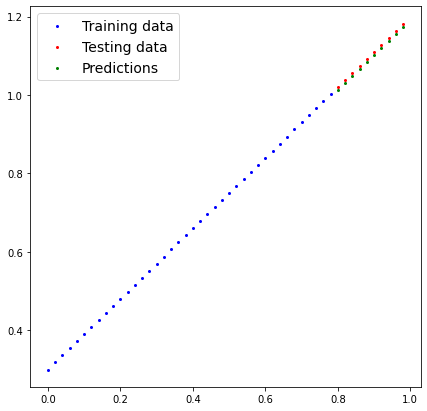

In [ ]:
plot_predictions(predictions=torch.tensor(model_test(X_test)).numpy())

## Exercices

In [ ]:
# importing module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

In [ ]:
# generating dump data
# params
weight = 5
bias = 2
# data
start = 0
end = 10
step = 0.5
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

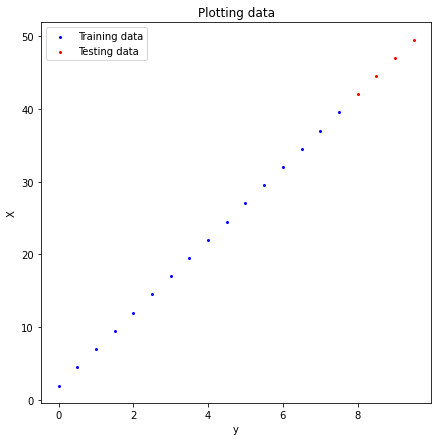

In [ ]:
# splitting data
train_set = int(0.8 * len(X))
X_train, y_train = X[:train_set], y[:train_set]
X_test, y_test = X[train_set:], y[train_set:]
# plotting data
def plot_predictions(X_train=X_train,
                     y_train=y_train,
                     X_test=X_test,
                     y_test=y_test,
                     predictions=None):
  plt.figure(figsize=(7,7))
  plt.scatter(X_train, y_train, c='b', s=4, label="Training data")
  plt.scatter(X_test, y_test, c='r', s=4, label="Testing data")
  if predictions is not None:
      plt.scatter(X_test, predictions, c='g', s=4, label="Predictions")
  plt.legend(loc='best')
  plt.xlabel('y')
  plt.ylabel('X')
  plt.title("Plotting data")
  plt.show()
plot_predictions()

In [ ]:
# Agnostic device code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# creating our regression model
class LinearRegressionModelV3(nn.Module):
  def __init__(self, device):
    super().__init__()
    # in_features == number of features 
    # out_features == dimension of our output
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1,
                                  device= device)
    
  def forward(self, x: torch.tensor) -> torch.tensor:
    return self.linear_layer(x)

  def train_loop(self, training_data,
                 testing_data,
                 lr=0.01,
                 epochs=400,
                 verbose=True
                 ):
    # data
    X_train, y_train = training_data
    X_test, y_test = testing_data

    # to device
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)

    # loss and optimizer
    loss_fn = nn.L1Loss()
    optimizer = torch.optim.SGD(params=self.parameters(),
                                lr = lr)
    
    # tracking
    epoch_count = []
    train_losses = []
    test_losses = []

    # let's loop
    for epoch in range(epochs):

      # train
      self.train()
      y_pred = self.forward(X_train)
      train_loss = loss_fn(y_pred, y_train)
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      # test
      self.eval()
      with torch.inference_mode():
        y_test_pred = self.forward(X_test)
        test_loss = loss_fn(y_test_pred, y_test)
      
      # track
      if epoch%10 == 0:
        epoch_count.append(epoch)
        train_losses.append(train_loss.cpu().item())
        test_losses.append(test_loss.cpu().item())
        if verbose:
          print(f"Epoch: {epoch} /  {epochs} | Train Loss = {train_loss} | Test Loss : {test_loss}")        
    return y_test_pred, epoch_count, train_losses, test_losses

  def save_model(self, model_path):
      torch.save(self.state_dict(), model_path)
    
  def load_model(self, model_path):
      self.load_state_dict(torch.load(model_path))

In [ ]:
# Let's run it
model_v2 = LinearRegressionModelV3(device)

In [ ]:
# train
training_data = (X_train, y_train) 
testing_data = (X_test, y_test)
predictions, epoch_count, train_losses, test_losses = model_v2.train_loop(training_data, testing_data)

Epoch: 0 /  400 | Train Loss = 17.070934295654297 | Test Loss : 37.411373138427734
Epoch: 10 /  400 | Train Loss = 15.564684867858887 | Test Loss : 34.03011703491211
Epoch: 20 /  400 | Train Loss = 14.058433532714844 | Test Loss : 30.648868560791016
Epoch: 30 /  400 | Train Loss = 12.5521821975708 | Test Loss : 27.267616271972656
Epoch: 40 /  400 | Train Loss = 11.04593563079834 | Test Loss : 23.88637351989746
Epoch: 50 /  400 | Train Loss = 9.539690017700195 | Test Loss : 20.5051326751709
Epoch: 60 /  400 | Train Loss = 8.033443450927734 | Test Loss : 17.123889923095703
Epoch: 70 /  400 | Train Loss = 6.527196884155273 | Test Loss : 13.74264907836914
Epoch: 80 /  400 | Train Loss = 5.020950794219971 | Test Loss : 10.361408233642578
Epoch: 90 /  400 | Train Loss = 3.5147037506103516 | Test Loss : 6.98016357421875
Epoch: 100 /  400 | Train Loss = 2.0084571838378906 | Test Loss : 3.598921775817871
Epoch: 110 /  400 | Train Loss = 0.5022110939025879 | Test Loss : 0.2176809310913086
Epoch:

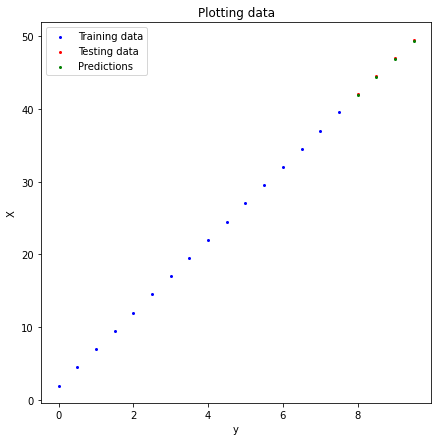

In [ ]:
plot_predictions(predictions=predictions.cpu())

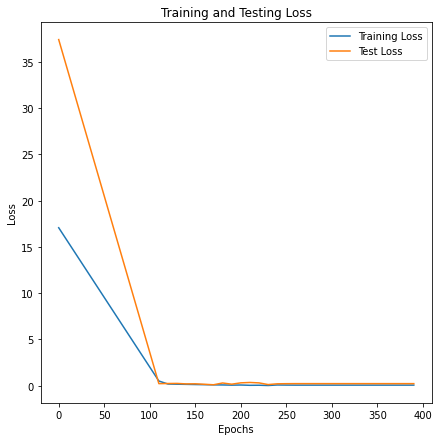

In [ ]:
# plotting the errors
def plot_loss(epoch_count=epoch_count,
              train_losses=train_losses,
              test_losses=test_losses):
  plt.figure(figsize=(7,7))
  plt.plot(epoch_count, train_losses, label="Training Loss")
  plt.plot(epoch_count, test_losses, label="Test Loss")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.title("Training and Testing Loss")
  plt.legend(loc='best')
  plt.show()
plot_loss()

In [ ]:
# let's save our model
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model_v2_1.pth"

MODEL_SAVE = MODEL_PATH / MODEL_NAME

model_v2.save_model(MODEL_SAVE)

In [ ]:
# loading model
model_v2_2 = LinearRegressionModelV3(device)
model_v2_2.load_model(MODEL_SAVE)
print(model_v2_2.state_dict())

OrderedDict([('linear_layer.weight', tensor([[4.9874]], device='cuda:0')), ('linear_layer.bias', tensor([1.9905], device='cuda:0'))])
